# Ascii to 64x64 image

## Import Necessary Libraries

In [28]:
from PIL import Image
import math
import numpy as np
import os

## Reading ascii image

In [29]:
# TWO NECESSARY THINGS TO CHANGE
# This is the text file that'll be used to generate the image
ascii_file_txt = 'input-txts/message-2.txt'
# This is the name of the folder you want it to be saved in
ascii_file_txt_name = 'message-2'

with open(ascii_file_txt) as ascii_image:
    ascii_image = ascii_image.readlines()
    
#print(ascii_image)

## Creating Value Dictionary

In [30]:
# List used to determine relative position of sublist items
FULL_ASCII_CHARS = ['@', '#', '$', 'B', '%', '?', '8', '&', 'W', 'M', '*', 'o', 'a', 'h', 'k', 'b', 'd', 'p', 'q', 'w', 'm', 'Z', 'O', '0', 'Q', 'L', 'C', 'J', 'U', 'Y', 'X', 'z', 'c', 'v', 'u', 'n', 'x', 'r', 'j', 'f', 't', '/', '\\', '|', '(', ')', '1', '{', '}', '[', ']', '-', '_', '+', '~', '<', '>', 'i', '!', 'l', 'I', ';', ':', ',', '^', '`', "'", '.', ' ']

# Removes all the \n characters
ascii_image = [ascii_line.replace('\n', '') for ascii_line in ascii_image]

# Finds all the unique characters in the image
unique_list = []
for row in range(len(ascii_image)):
    for cell in range(len(ascii_image[row])):
        if(ascii_image[row][cell] not in unique_list):
            unique_list.append(ascii_image[row][cell])
#print(unique_list)

# Sorts the list of ascii characters relative to the FULL_ASCII_CHARS list
sorted_unique_list = sorted(unique_list, key=FULL_ASCII_CHARS.index)
#print(sorted_unique_list)

# Generates the Step Value
sorted_list_length = len(sorted_unique_list)
color_distance = 255 / sorted_list_length
color_distance = math.floor(color_distance)

# Outputs the final dictionary
sorted_list_dictionary = {item: int(index * color_distance) for index, item in enumerate(sorted_unique_list)}
#print(sorted_list_dictionary)

## Generating Image

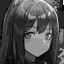

In [31]:
low_res_bw_decode_array = []
for row in range(len(ascii_image)):
    current_row = []
    for cell in range(len(ascii_image[row])):
        current_row.append(sorted_list_dictionary[ascii_image[row][cell]])
    
    low_res_bw_decode_array.append(current_row)
    
#print(low_res_bw_decode_array)

low_res_bw_decode_numpy = np.array(low_res_bw_decode_array)

low_res_bw_decode_image = Image.fromarray(low_res_bw_decode_numpy.astype('uint8'))

# Shows the image
display(low_res_bw_decode_image)

# Saves the image
# Check if folder exists
if not os.path.exists("output-imgs/" + ascii_file_txt_name):
    # If not, then create it
    os.makedirs("output-imgs/" + ascii_file_txt_name)

low_res_bw_decode_image.save("output-imgs/" + ascii_file_txt_name + "/0-64-hc-bw-image.png")

# 64x64 image to 256x256 image

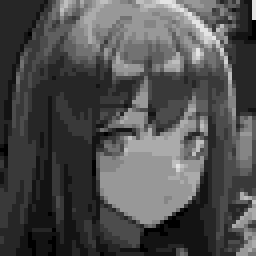

In [32]:
# Upscales the image
upscaled_img = low_res_bw_decode_image.resize((256,256), Image.NEAREST)

# Displays the image
display(upscaled_img)

# Saves the image
upscaled_img.save("output-imgs/" + ascii_file_txt_name + "/1-256-hc-bw-image.png")

# 256x256 to Smooth image

In [33]:
import torch
from torch import nn
from torchvision.transforms import ToTensor, Resize, Normalize, ToPILImage
from PIL import Image
import torchvision.utils as vutils
import os

In [34]:
# Load and preprocess the image
from torchvision.transforms import Compose

def convert_to_rgb(tensor):
    return tensor.repeat(1, 3, 1, 1)

def load_image_bw(img_path):
    if isinstance(img_path, str):
        img = Image.open(img_path).convert('L')
    elif isinstance(img_path, Image.Image):
        img = img_path.convert('L')
    else:
        raise ValueError("Invalid input type")
        
    transform = Compose([
        Resize((256, 256)),  # Resize to the size expected by the model
        ToTensor(),
        Normalize((0.5,), (0.5,))  # Adjusted for grayscale
    ])
    img = transform(img).unsqueeze(0)  # Add batch dimension
    return img

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class ResnetBlock_bw(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock_bw, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
        ]
        return nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator_bw(nn.Module):
    def __init__(self, input_nc=1, output_nc=1, ngf=64, n_blocks=9):
        assert(n_blocks >= 0)
        super(Generator_bw, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),
        ]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True),
            ]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock_bw(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True),
            ]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

In [36]:
def Ai_img_augmentation_bw(img, output_path):
    # Load the model
    model = Generator_bw()
    model.load_state_dict(torch.load('models/bw-smoothing-model.pth'))
    model.eval()
    
    # Load image and convert
    input_image = load_image_bw(img)
    with torch.no_grad():
        output = model(input_image)
        output_rgb = convert_to_rgb(output)
    
    # Save the generated image
    vutils.save_image(output_rgb, output_path, normalize=True)
    
    # Convert tensor to numpy array
    output_np = output_rgb.cpu().numpy()
    
    # Squeeze the batch and channel dimensions and convert the range from [-1, 1] to [0, 255]
    output_np = np.squeeze(output_np)[0]
    output_np = ((output_np + 1.0) / 2.0 * 255.0).astype('uint8')
    
    # Create a PIL Image
    output_pil = Image.fromarray(output_np, 'L')
    
    return output_pil

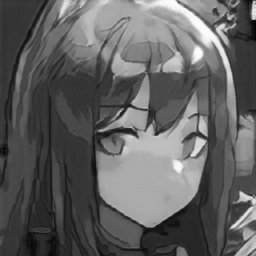

In [37]:
input_folder = 'input-imgs'
output_folder = "output-imgs/" + ascii_file_txt_name
filename = '2-256-bw-image.png'

# NEED TO MAKE IT SAVE IMAGE AS VARIABLE AND SAVE IN FOLDER
ai_aug_image = Ai_img_augmentation_bw(upscaled_img, os.path.join(output_folder, filename))
display(ai_aug_image)

# Smooth image to Color image

In [38]:
def load_image(img_path):
    if isinstance(img_path, str):
        img = Image.open(img_path).convert('RGB')
    elif isinstance(img_path, Image.Image):
        img = img_path.convert('RGB')
    else:
        raise ValueError("Invalid input type")
    
    transform = Compose([
        Resize((256, 256)),  # Resize to the size expected by the model
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for RGB
    ])
    img = transform(img).unsqueeze(0)  # Add batch dimension
    return img

In [39]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
            nn.InstanceNorm2d(dim),
        ]
        return nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9):
        assert(n_blocks >= 0)
        super(Generator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),
        ]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [
                nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(ngf * mult * 2),
                nn.ReLU(True),
            ]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=True),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True),
            ]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)

In [40]:
def Ai_img_augmentation(img, output_path):
    # Load the model
    model = Generator(input_nc=3, output_nc=3)
    model.load_state_dict(torch.load('models/color-model.pth'))
    model.eval()
    
    # Load image and convert
    input_image = load_image(img)
    with torch.no_grad():
        output = model(input_image)
    
    # Save the generated image
    vutils.save_image(output, output_path, normalize=True)

In [41]:
input_folder = 'input-imgs'
output_folder = "output-imgs/" + ascii_file_txt_name
filename = '3-256-bw-image.png'

final_image_gen = Ai_img_augmentation(ai_aug_image, os.path.join(output_folder, filename))